In [1]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

# Preprocessing
from imblearn.under_sampling import RandomUnderSampler #conda install conda-forge::imbalanced-learn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
# nltk.download('punkt')
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem import PorterStemmer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC,ADASYN

# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV


# Score of models
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score

Notre objectif fut de créer un petit script permettant de filtrer les spams à l'aide d'un modèle de machine learning.

PREPROCESSING

In [3]:
#fonction de mise en place du dataset 
def cree_df(url = "SMSSpamCollection.txt"):
    df = pd.read_csv(url, sep='\t', header=None )
    df.rename(columns={0:'type',1:'mail'}, inplace=True)
    return df

Nous avions à disposition un dataset de messages sms (ou mail?) permettant d'entrainer notre futur modèle à reconnaitre les spam. ici on l'implémente et renomme les colonnes afin d'avoir une meilleure visibilité.

In [2]:
#création d'une blacklist de mots de spam 
dfblacklist = pd.read_csv('spam_words.txt', header=None, on_bad_lines='skip' )
dfblacklist.rename(columns={0:'words'}, inplace=True)
dfblacklistList = dfblacklist['words'].tolist()

L'une de nos idée fut de créer à tout prix une liste retournant uniquement les mots utilisé dans les spams. surnommé "blacklist", cette liste en format txt va permettre au modèle de s'entraîner à retrouver les spams en s'aidant de cette liste mais bien sûr nous avions prévu d'autres feature.

In [4]:
#fonction de préparation des données (preprocessing)
def prep(df): 

    #lowercase des message
    df['minuscule']=df['mail'].str.lower()

    #mise en place des tokens des message
    tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}")
    df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))

    #ajout d'un stopwords 
    stop = stopwords.words('english')
    df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])

    #ajout d'un stemmer
    stemmer = PorterStemmer()
    df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    
    #regroupement du traitement des données
    df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
    return df

Nous commençons à rentrer dans le preprocessing : ici nous affinons le dataset permettant ainsi une meilleure utilisation et visibilité pour le modèle. Chaque étape est implémenter dans une nouvelle colonne du dataframe à partir de la précédente, celà permet de d'observer le changement entre chaque étape. Nous débutons par transformer les messages en miniatures. par la suite nous ajoutons une nouvelle colonne en token avec un regex (à préciser?). Ensuite une nouvelle colonne de stop words. puis une colonne stemmer et enfin nous regroupons le tout dans une colonne clean, celle que l'on va utiliser.

In [5]:
#fonction d'ajout des features afin d'améliorer la précision des modèles
def features(df):
    
    #ajout d'une feature "longueur du message"
    df['len']=df['mail'].str.len()

    #ajout d'une feature "nombre de mots"
# df['nombre_mots']=df['mail'].str.split().str.len()
    df['nombre_mots']=df['token'].str.len()

    #ajout d'une feature permettant de vérifier si présence d'hypertexte
    pattern = r"http\S+|www.\S+"
    df['http']=df['mail'].apply(lambda x : True if re.search(pattern, x) else False)

    #ajout d'une feature permettant de vérifier la présence de chiffre 
    pattern = r"/^[\(]?[\+]?(\d{2}|\d{3})[\)]?[\s]?((\d{6}|\d{8})|(\d{3}[\*\.\-\s]){3}|(\d{2}[\*\.\-\s]){4}|(\d{4}[\*\.\-\s]){2})|\d{8}|\d{10}|\d{12}$/"
    df['phone']=df['mail'].apply(lambda x : True if re.search(pattern, x) else False)
    
    #ajout d'une feature permettant de vérifier la présence de mail
    pattern = r"[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+(?:\.[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+)*@(?:[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?\.)+[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?"
    df['mail_compt']=df['mail'].apply(lambda x : True if re.search(pattern, x) else False)

    #ajout d'une feature permettant de vérifier la présence de mots blacklisté 
    df['blacklist']=df['token'].apply(lambda x: len([ word for word in x if word  in dfblacklistList]))
    return df

Ceci est notre petite sauce secrete. l'ajout de features permettant d'améliorer la précision de notre future modèle. comme pour le preprocessing chaque feature sera ajouter dans le dataframe en tant que nouvelle colonne mais cette fois toute excepte la blacklist et nombre_mots se serviront de la colonne mail. 
la colonne http retourne un boolean si un lien hypertexte est présent dans le message
la colonne phone retourne un boolean si un numéro de téléphone est présent dans le message
la colonne len retourne la longueur du message
la colonne mail_compt retourne un boolean si un mail est présent dans le message

les deux dernière colonnes se servent cependant de la colonne token
la colonne nombre_mots retourne le nombre total de mot dans le message
la colonne blacklist retourne le nombre de mots blacklisté présent dans le message 

<Axes: title={'center': 'blacklist'}, xlabel='type'>

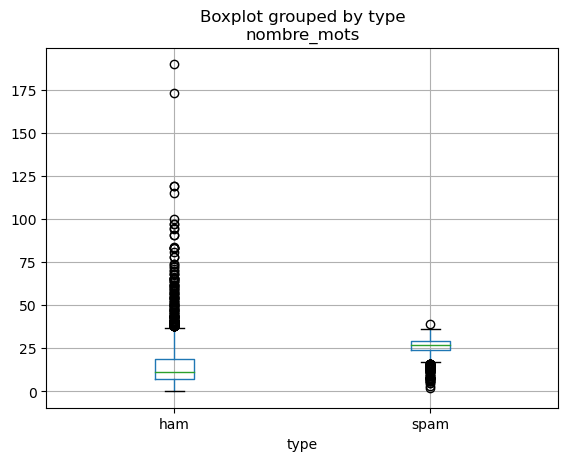

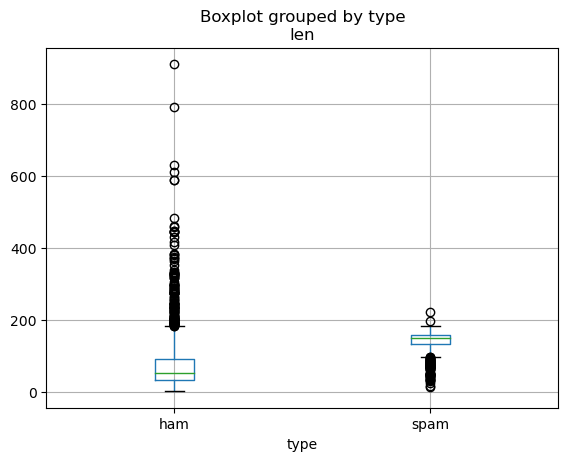

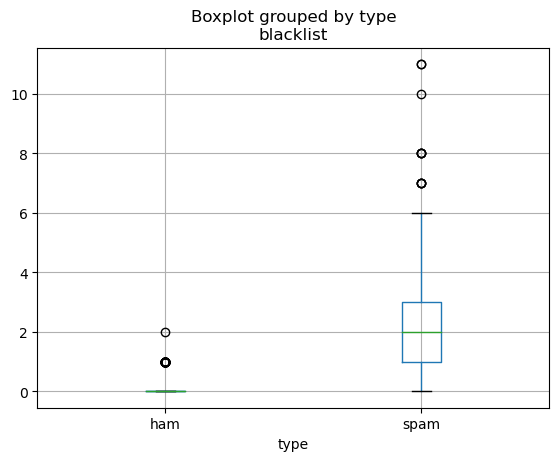

In [6]:

#appel des fonctions
dfModel = cree_df("SMSSpamCollection.txt")
dfModel = prep(dfModel)
dfModel = features(dfModel)
#affichage des boxplot des colonnes nombre_mots, len et blacklist
dfModel[['type', 'nombre_mots']].boxplot(column='nombre_mots', by='type')
dfModel[['type', 'len']].boxplot(column='len', by='type')
dfModel[['type', 'blacklist']].boxplot(column='blacklist', by='type')



Nous commençons donc notre étude et nous observons bien une différence lorsqu'on vérifie les données dans les colonnes len, nombre_mots et blacklist. 
Dans la colonne nombre_mots on remarque bien un décalage entre les "ham" et les "spam". Généralement les ham ont moins de 25 mots alors que les spams ont à minima 25 mots. On voit cependant un nombre conséquent d'outliers supérieur au nombre "normale" des ham tandis que pour les outliers des spams sont inférieurs majoritairement

on remarque exactement la même chose dans la colonne len, toujours un décalage en faveurs des spam tout comme au niveau des outliers.

cependant dans la colonne blacklist, ce qui est intéréssant c'est qu'on voit bien la différence, les spam utilisent bien similairement des mots 

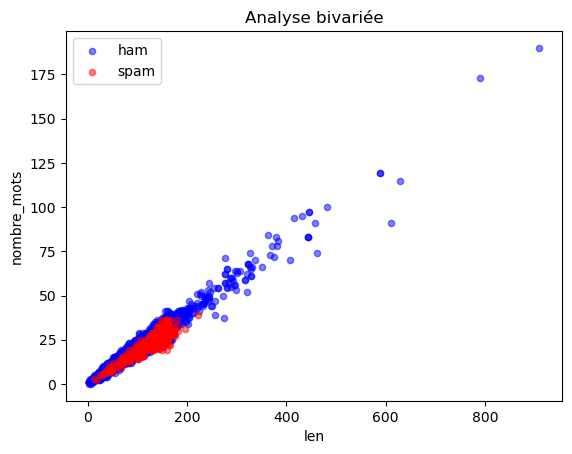

In [7]:

fig, ax = plt.subplots()

for key, group in dfModel.groupby('type'):
    
    if key=='spam':
        c='red'
    else:
        c='blue'
    group.plot.scatter(ax=ax, x='len', y='nombre_mots', label=key, c=c, alpha=0.5)
plt.title('Analyse bivariée')
plt.show()

Ici on établi une analyse bivariée pour observer le nombre mots par rapport à la longueur du message on observe bien que les spams sont compacté entre eux tandis que les ham sont beaucoup plus dispercer. On observe donc que les spams ont peut-être une limite maximum et sont donc automatisé.

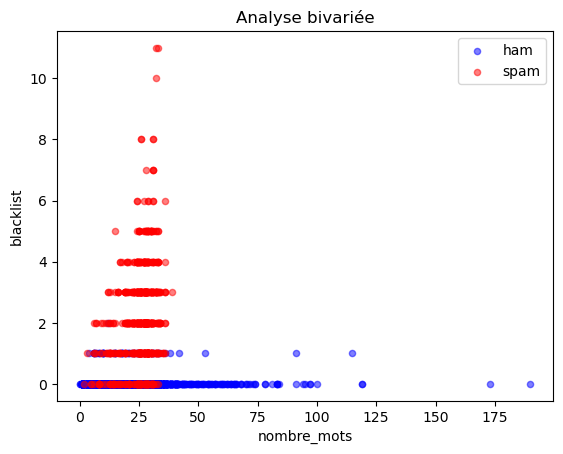

In [8]:

fig, ax = plt.subplots()

for key, group in dfModel.groupby('type'):
    
    if key=='spam':
        c='red'
    else:
        c='blue'
    group.plot.scatter(ax=ax, x='nombre_mots', y='blacklist', label=key, c=c, alpha=0.5)
plt.title('Analyse bivariée')
plt.show()

Voici une autre analyse bivariée oû cette fois-ci c'est le nombre de mots blacklisté par rapport aux nombres de mots par message. on remarque toujours que les spam une limite à ne pas dépasser qui donc renforce nos doutes à propos de l'automatisation mais en plus on remarque que les occurences des mots blacklisté sont bien présent surtout au niveau des spams. 

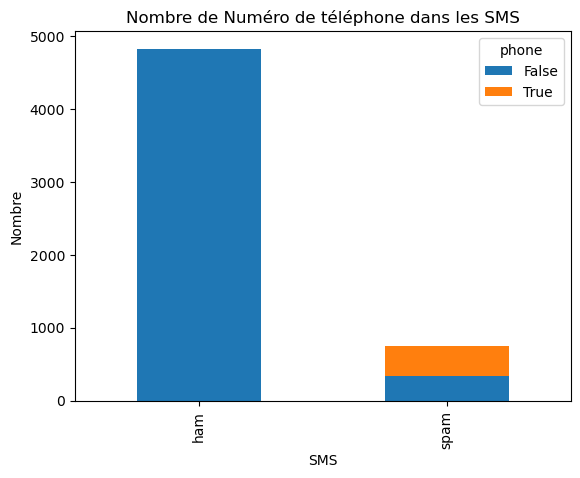

In [9]:
#Nombre de Numéro de téléphone dans les SMS
pivot_table = dfModel[['type', 'phone']].pivot_table(index='type', columns='phone', aggfunc=len, fill_value=0)
pivot_table.plot(kind='bar', stacked=True)

plt.title('Nombre de Numéro de téléphone dans les SMS')
plt.xlabel('SMS')
plt.ylabel('Nombre')
plt.show()

Ici on observe une analyse univariée de la présence des numéros de téléphone dans les messages. On remarque très facilement que les numéros de téléphone sont uniquement présent dans les spams. Cette informations est extrêmement utile car elle permet d'aider à identifier un spam facilement

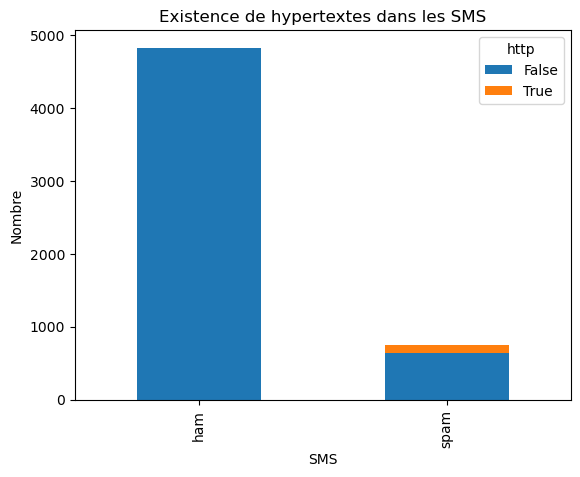

In [10]:
#Existence de hypertextes dans les SMS
pivot_table = dfModel[['type', 'http']].pivot_table(index='type', columns='http', aggfunc=len, fill_value=0)
pivot_table.plot(kind='bar', stacked=True)

plt.title('Existence de hypertextes dans les SMS')
plt.xlabel('SMS')
plt.ylabel('Nombre')
plt.show()

Nous effectuons la même observation si on observe la présence d'hypertexte par rapport au message. et nous avons la même observation que les numéros de téléphones. la présence d'hypertexte n'est que dans les spam même s'il y en a peu ce qui peut aider encore plus à les différencier

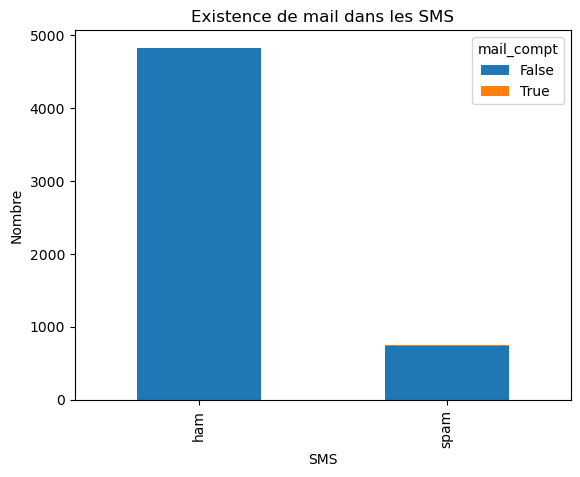

In [11]:
#Existence de mail dans les SMS
pivot_table = dfModel[['type', 'mail_compt']].pivot_table(index='type', columns='mail_compt', aggfunc=len, fill_value=0)
pivot_table.plot(kind='bar', stacked=True)
plt.title('Existence de mail dans les SMS')
plt.xlabel('SMS')
plt.ylabel('Nombre')
plt.show()

Pour finir nous observons la présence de mail par rapport aux messages et nous observont malgré tout une infime portion de mail présent uniquement dans les spam. Malgré cette maigre information, elle reste importante et déterminante pour différencier d'un spam

In [12]:
dfModel[dfModel['mail_compt']==True]

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean,len,nombre_mots,http,phone,mail_compt,blacklist
136,ham,I only haf msn. It's yijue@hotmail.com,i only haf msn. it's yijue@hotmail.com,"[i, only, haf, msn, it, s, yijue, hotmail, com]","[haf, msn, yijue, hotmail, com]","[haf, msn, yiju, hotmail, com]",haf msn yijue hotmail com,38,9,False,False,True,0
1613,spam,RT-KIng Pro Video Club>> Need help? info@ringt...,rt-king pro video club>> need help? info@ringt...,"[rt, king, pro, video, club, need, help, info,...","[rt, king, pro, video, club, need, help, info,...","[rt, king, pro, video, club, need, help, info,...",rt king pro video club need help info ringtone...,153,27,True,True,True,1
2313,spam,tddnewsletter@emc1.co.uk (More games from TheD...,tddnewsletter@emc1.co.uk (more games from thed...,"[tddnewsletter, emc1, co, uk, more, games, fro...","[tddnewsletter, emc1, co, uk, games, thedailyd...","[tddnewslett, emc1, co, uk, game, thedailydraw...",tddnewsletter emc1 co uk games thedailydraw de...,114,17,False,False,True,0
2548,spam,"Text82228>> Get more ringtones, logos and game...","text82228>> get more ringtones, logos and game...","[text82228, get, more, ringtones, logos, and, ...","[text82228, get, ringtones, logos, games, www,...","[text82228, get, rington, logo, game, www, txt...",text82228 get ringtones logos games www txt822...,101,16,True,False,True,0
3501,spam,Dorothy@kiefer.com (Bank of Granite issues Str...,dorothy@kiefer.com (bank of granite issues str...,"[dorothy, kiefer, com, bank, of, granite, issu...","[dorothy, kiefer, com, bank, granite, issues, ...","[dorothi, kiefer, com, bank, granit, issu, str...",dorothy kiefer com bank granite issues strong ...,156,26,False,False,True,1
4906,spam,Warner Village 83118 C Colin Farrell in SWAT t...,warner village 83118 c colin farrell in swat t...,"[warner, village, 83118, c, colin, farrell, in...","[warner, village, 83118, c, colin, farrell, sw...","[warner, villag, 83118, c, colin, farrel, swat...",warner village 83118 c colin farrell swat wken...,181,36,False,False,True,2
5102,spam,This msg is for your mobile content order It h...,this msg is for your mobile content order it h...,"[this, msg, is, for, your, mobile, content, or...","[msg, mobile, content, order, resent, previous...","[msg, mobil, content, order, resent, previou, ...",msg mobile content order resent previous attem...,153,26,False,False,True,1


Discriminante

In [13]:
#fonction permettant la spéaration de la target des autres colonnes (création X et y)

def spliteur(df):
    X = df.drop(columns = ['type'], axis=1)
    y = df['type']
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    #return train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    return train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

In [14]:
def spliteur_simple(df):
    X = df.drop(columns = ['type'], axis=1)
    y = df['type']
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [15]:
def SMOTE_simple(df):
    X = df[['clean','len','nombre_mots','blacklist','http','phone','mail_compt']]
    y = df['type']
    rus = SMOTENC(random_state=42, categorical_features=[0])
    X_res, y_res = rus.fit_resample(X, y)
    #return train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    return train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

Ici nous avons créé trois fonctions de split, elle sont similaire cependant la fonction spliteur s'occupe d'un problème très important qu'on a pas encore mis en avant : Celui des données déséquilibrée. En effet le dataset présent un nombre anormalement inégale de ham par rapport au spam. Si nous utiliser le spliteur_simple. Lorsque nous allons entrainer le modèle avec le X_train, ce dernier sera biaisé au niveau des ham et ne reconnaitra que très rarement un scam. Pour remédier à celà nous avons procédé à deux méthode : L'underfitting et l'overfitting. L'underfitting est la méthode de suppression des donnée de la ou des classes provoquant le déséquilibre et l'overfitting est la méthode de l'ajout de nouvelle donnée de la ou des classes ayant le moins de données. Dans notre cas, le dataset a trop peu de données pour se permettre de l'underfitting. Nous utiliserons la méthode de l'overfitting avec la librairie SMOTENC(à préciser)

In [16]:
#fonction création du modèle 
def ModelCreateur(X_train, y_train, classifier):

    column_num  = ['len','nombre_mots','blacklist']
    column_bool = ['http','phone','mail_compt']
    column_text = 'clean'
    #Transformation des variables texte
    transfo_text_TFid = Pipeline(steps=[
        ('Tfid', TfidfVectorizer(lowercase=False, decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2)))
        
    ])

#Application des étapes sur tout le dataset
    if isinstance(classifier, ComplementNB) or isinstance(classifier, MultinomialNB) or isinstance(classifier, BernoulliNB):
        preparation = ColumnTransformer(
        transformers=[
        ('TFid&data', transfo_text_TFid , column_text), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , column_text),
            ('Scaler&data',MinMaxScaler(), column_num),
            ('BoolEncoder',OrdinalEncoder(), column_bool)
        ])
    else : 
        preparation = ColumnTransformer(
        transformers=[
        ('TFid&data', transfo_text_TFid , column_text), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , column_text),
            ('Scaler&data',RobustScaler(), column_num),
            ('BoolEncoder',OrdinalEncoder(), column_bool)
        ])
    
    #relie l'algorithme avec le modèle
    model = Pipeline([
    ('vectorizer', preparation),
    
    ('model', classifier)
    ])
    #Fit le modèle
    model.fit(X_train, y_train)
    return model

cette fonction est importante puisqu'elle va créer le modèle : en fonction des différents types de variable, nous devons procéder à une préparation. Pour les données en type string nous procédons à une vectorisation à l'aide du vectorizer TF-IDF que l'ont intègre dans un pipeline. Pour les variables numérique, nous allons utlisé un scaler, cependant certains modèle tel que le MultinomialNB (généralement tout les modèles naive bayes) ne peuvent pas être convertie à l'aide d'un robuste scaler car ce dernier retourne des données négatives dans la matrice nous devons procéder à une vérification et de changer le scaler en fonction du modèle. Le minMaxscaler est parfait car ce dernier retourne une matrice entre 0 et 1. Enfin pour les données boolean nous procédons à un encoding des données à l'aide du ordinal encoder. Pour les utiliser ensemble nous les regroupons à l'aide d'un ColumnTransformer qui permet de regrouper les différents types de variable avec leur propre modification. Enfin nous utilisons un dernier pipeline pour regrouper le modèle et la préparation. et nous finission par un fitting des données pour entamer l'entrainement. 

In [17]:
# fonction qui affiche la matrice de confusion du modèle
def matrixconf(y_test,y_pred):
    #affiche la matrice de confusion du modèle
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Cette fonction permet d'afficher la matrice de confusion. une matrice de confusion permet de vérifier les données analysé et de remarquer si le modèle s'est bien entrainé en fonction de la donné positive. 

In [18]:
# Modites c le dictionnaire des modèles avec les paramètres de test
def modeleslist():
    models = {
        'LogisticRegression': {
            'model': LogisticRegression(),'param': {'model__solver':['liblinear', 'saga'],
                                                    'model__penalty': ['l1', 'l2'],
                                                    'model__C':[0.1, 1, 10]}
        },
        'ComplementNB': {
            'model': ComplementNB(),'param': {'model__alpha': (0.1, 0.5, 1.0)}
        },
        'BernoulliNB': {
            'model': BernoulliNB(),'param': {'model__alpha': [0.0, 1.0, 10.0],
                                              'model__binarize': [None, 0.0, 0.5, 1.0]}
        },        
        'SVC': {
            'model': SVC(),'param': {'model__kernel':('linear', 'rbf'),
                                     'model__C':[1, 10]}
        },
        'RandomForestClassifier': {
            'model': RandomForestClassifier(),'param': {'model__n_estimators': [200, 300],
                                                        'model__max_depth': [10, 30]}
        
        },
        'DecisionTreeClassifier': {
            'model': DecisionTreeClassifier(),'param': {'model__criterion': ['gini', 'entropy'],
                                                        'model__splitter': ['best', 'random'],
                                                        'model__max_depth': [10, 30]
                                                        }
        
        },
        'KNeighborsClassifier': {
            'model': KNeighborsClassifier(),'param': {'model__n_neighbors': [3, 7],
                                                      'model__weights': ['uniform', 'distance'],
                                                    'model__algorithm': ['auto', 'ball_tree']}
        
        },
        'RidgeClassifier': {
            'model': RidgeClassifier(),'param': {'model__alpha': [0.1, 1.0,10],
                                                 'model__solver': ['auto']
                                                 }
        }
    }
    return models

Cette fonction permet d'instancier les modèle avec leur propre paramètre dans une liste permettant de les récupérer plus tard afin d'entrainer plusieurs modèle à la fois

In [19]:
list_model = modeleslist()
X_train, X_test, y_train, y_test = SMOTE_simple(dfModel)

In [20]:
def gridCreateur(pipe, parametre):
    
    # grid = GridSearchCV(pipe, parametre, scoring=Scoring_list, refit='roc_auc', cv = 5, n_jobs =-1, verbose = 1)
    R = make_scorer(recall_score, pos_label='spam')
    P = make_scorer(precision_score, pos_label='spam')
    Scoring_list= {'Myrecall':R, 'MyPrecision':P, 'roc':'roc_auc'}
    grid = GridSearchCV(pipe, parametre, scoring=Scoring_list, refit='Myrecall',cv = 5, n_jobs =-1, verbose = 1)
    # Fit the model
    grid.fit(X_train, y_train)
    return grid


Cette fonction permet d'utliser la librairie GridSearchCV qui est un estimateur qui va effectué diverse action permettant d'entrainer notre modèle en fonction du nombre de cross validation 

In [21]:
#fonction permettant de connaître le score de notre modèle
def AfficherScores(model,y_test, y_pred):
    
    classifier_name = model.best_estimator_.named_steps['model'].__class__.__name__
    print(f"--------------------------------{classifier_name}-------------------------------------------------")
    
    #affiche la classification rapport du modèle
    print(classification_report(y_test, y_pred))
    print(f"{classifier_name} ---> Accuracy score:", accuracy_score(y_test, y_pred))
    print(f"{classifier_name} ---> Best parameters: {model.best_params_}")
    print(f"{classifier_name} ---> Best score: {model.best_score_}")
    
    
    disp = matrixconf(y_test,y_pred)
    plt.title(f"Matrice de confusion de {classifier_name} ")
    plt.show()
    
    disp = RocCurveDisplay.from_estimator(model,X_test,y_test)
    plt.title(f"Courbe ROC de {classifier_name} ")
    plt.show()


cette fonction permet d'afficher le score de notre modèle en le faisant tester sur les données de test séparé X. d'afficher sa matrice de confusion et la courbe ROC (à préciser)

In [22]:
#Testmodet armée de préparer le texte du SMS et de predire une classification
def testModel(sms,model):

    df_sms = pd.DataFrame({'type': ['test'], 'mail': [sms]})
    df_sms        = prep(df_sms)
    df_sms        = features(df_sms)
    result = model.predict(df_sms)
    return result

la fonction testModel retourne le résultat de la prédiction d'un spam ou d'une liste de spams

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


--------------------------------LogisticRegression-------------------------------------------------
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       965
        spam       1.00      1.00      1.00       965

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

LogisticRegression ---> Accuracy score: 0.9958549222797928
LogisticRegression ---> Best parameters: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
LogisticRegression ---> Best score: 0.9906735751295337


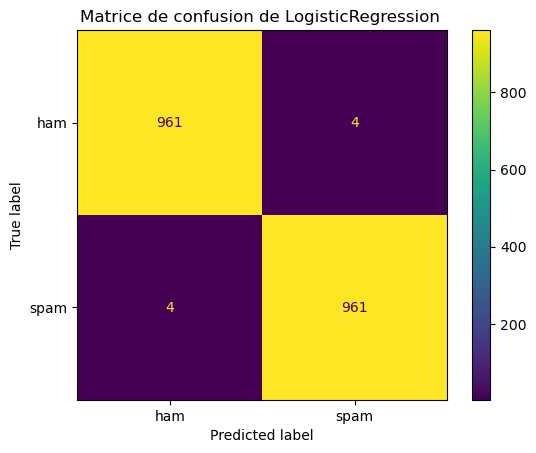

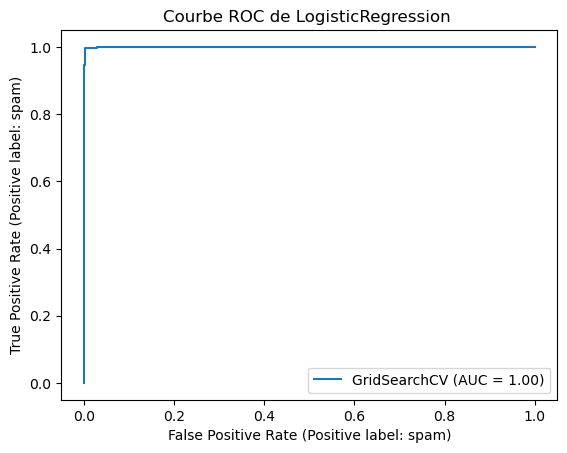

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


--------------------------------ComplementNB-------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       965
        spam       0.99      0.97      0.98       965

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930

ComplementNB ---> Accuracy score: 0.977720207253886
ComplementNB ---> Best parameters: {'model__alpha': 0.1}
ComplementNB ---> Best score: 0.9619170984455959


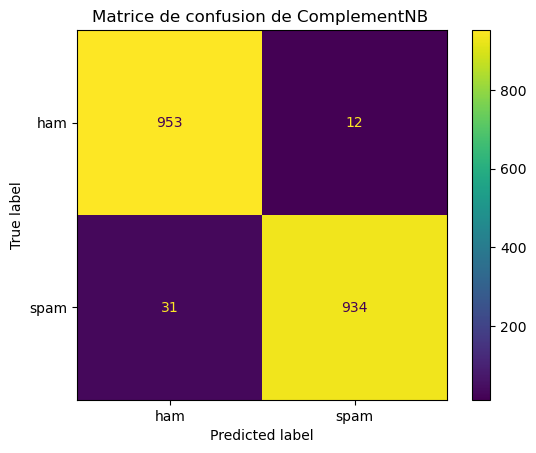

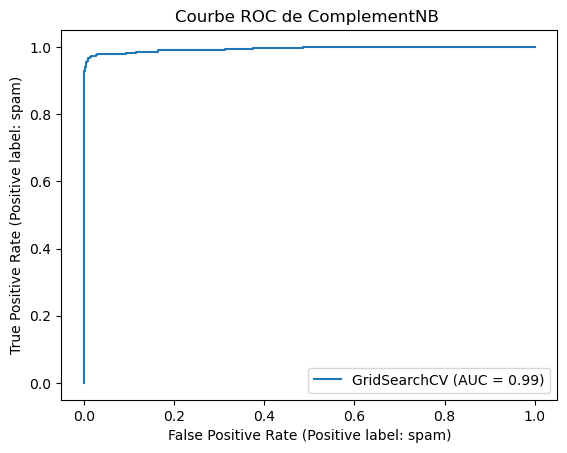

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


--------------------------------BernoulliNB-------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       965
        spam       0.99      0.97      0.98       965

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930

BernoulliNB ---> Accuracy score: 0.9787564766839378
BernoulliNB ---> Best parameters: {'model__alpha': 0.0, 'model__binarize': None}
BernoulliNB ---> Best score: 0.966839378238342


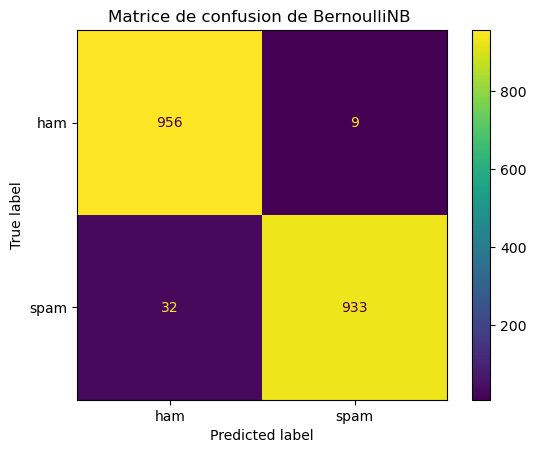

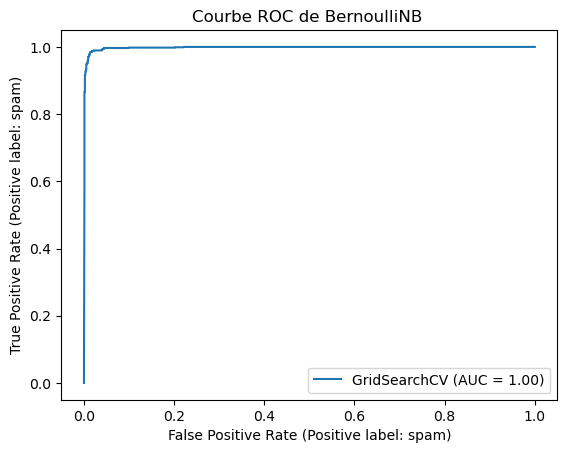

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


--------------------------------SVC-------------------------------------------------
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       965
        spam       1.00      1.00      1.00       965

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

SVC ---> Accuracy score: 0.9979274611398964
SVC ---> Best parameters: {'model__C': 10, 'model__kernel': 'rbf'}
SVC ---> Best score: 0.9948186528497409


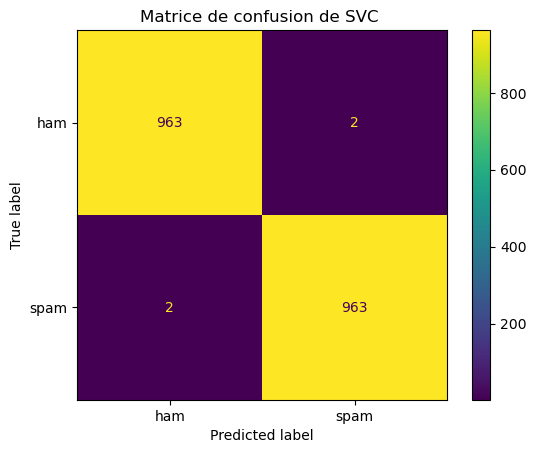

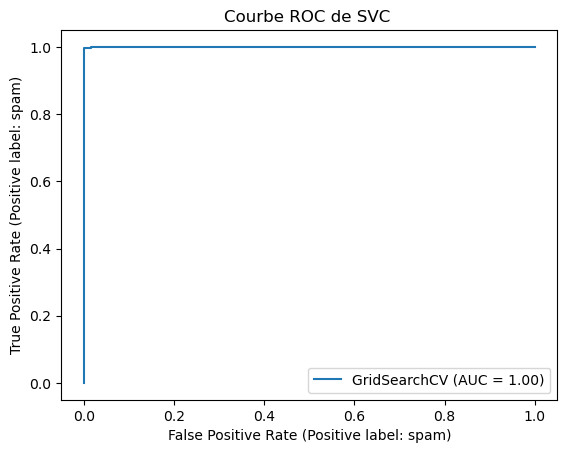

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


--------------------------------RandomForestClassifier-------------------------------------------------
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       965
        spam       1.00      1.00      1.00       965

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

RandomForestClassifier ---> Accuracy score: 0.9979274611398964
RandomForestClassifier ---> Best parameters: {'model__max_depth': 30, 'model__n_estimators': 200}
RandomForestClassifier ---> Best score: 0.9950777202072538


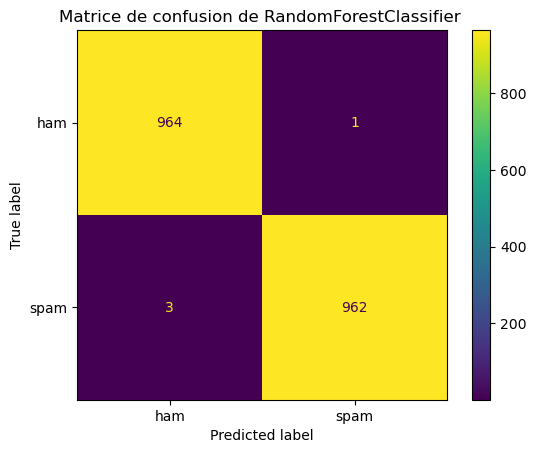

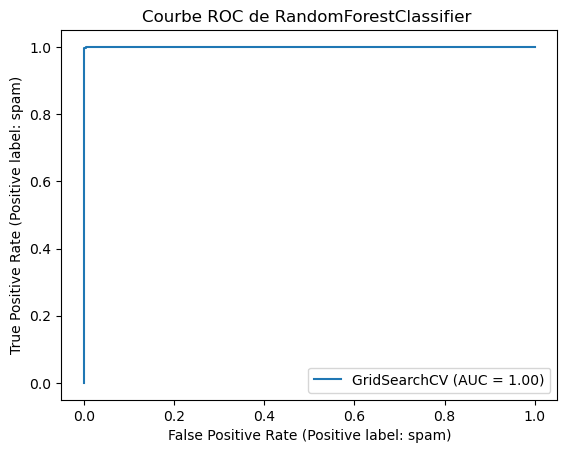

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


--------------------------------DecisionTreeClassifier-------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       965
        spam       0.99      0.99      0.99       965

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930

DecisionTreeClassifier ---> Accuracy score: 0.9922279792746114
DecisionTreeClassifier ---> Best parameters: {'model__criterion': 'gini', 'model__max_depth': 30, 'model__splitter': 'best'}
DecisionTreeClassifier ---> Best score: 0.9880829015544041


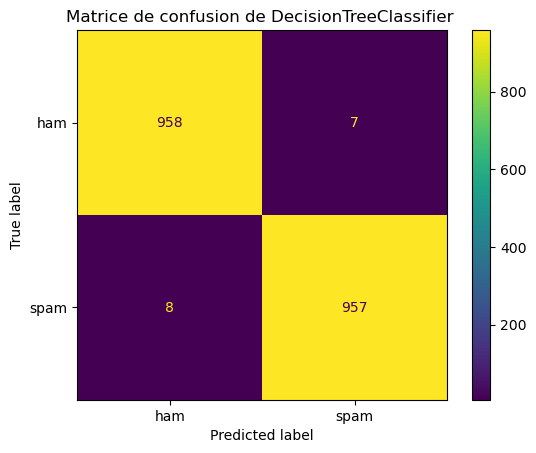

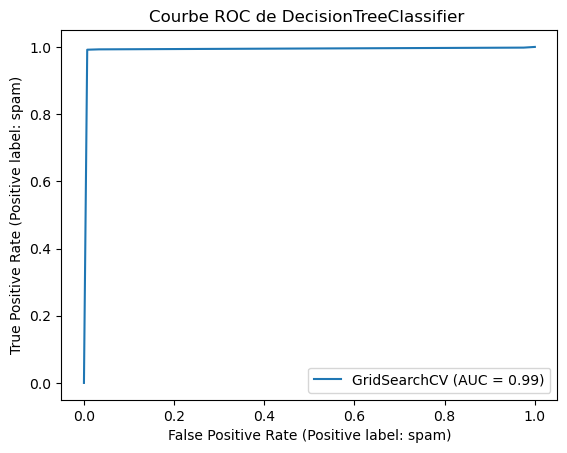

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


--------------------------------KNeighborsClassifier-------------------------------------------------
              precision    recall  f1-score   support

         ham       1.00      0.99      1.00       965
        spam       0.99      1.00      1.00       965

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

KNeighborsClassifier ---> Accuracy score: 0.9953367875647668
KNeighborsClassifier ---> Best parameters: {'model__algorithm': 'auto', 'model__n_neighbors': 3, 'model__weights': 'distance'}
KNeighborsClassifier ---> Best score: 0.994559585492228


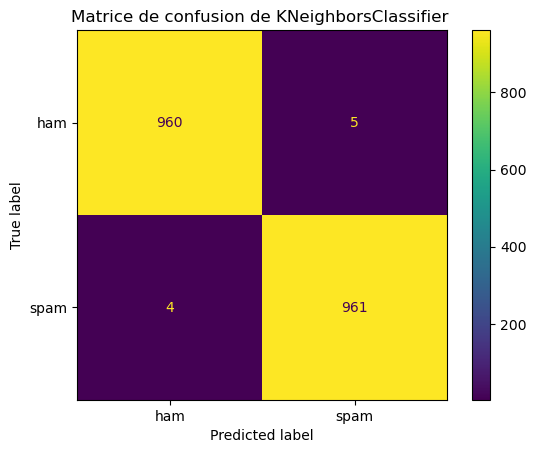

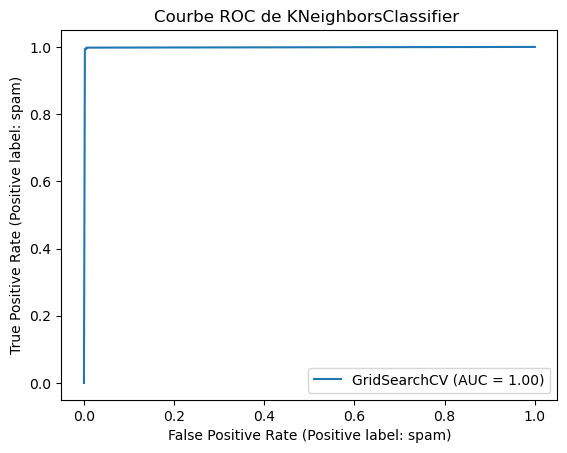

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


--------------------------------RidgeClassifier-------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       1.00      0.99      0.99       965

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930

RidgeClassifier ---> Accuracy score: 0.9937823834196892
RidgeClassifier ---> Best parameters: {'model__alpha': 0.1, 'model__solver': 'auto'}
RidgeClassifier ---> Best score: 0.9847150259067357


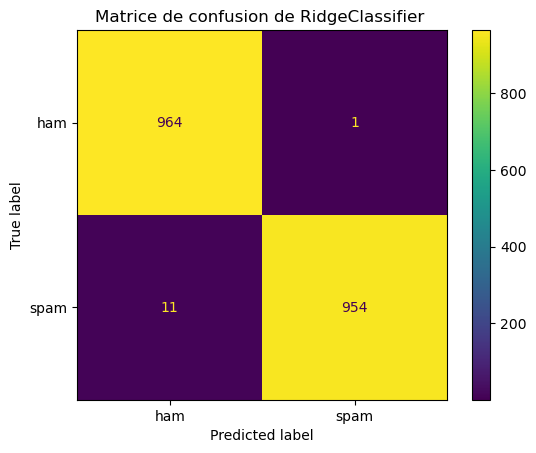

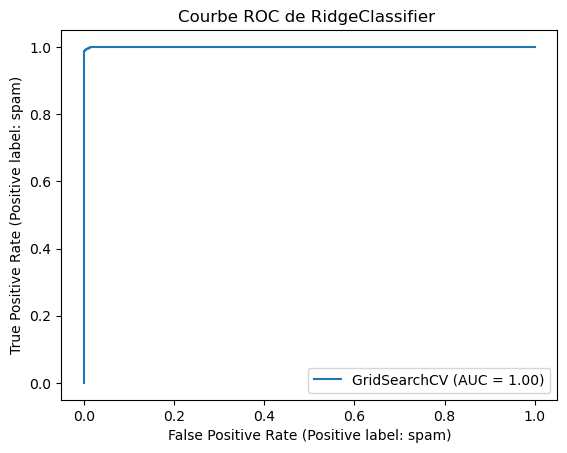

In [23]:
#C'est la boucle pour entraîner tous les modèles du dictionnaire

Modele_dic={}
for model_name, model_params in list_model.items():

    model_lm = ModelCreateur(X_train, y_train, list_model[model_name]['model'])
    grid=gridCreateur(model_lm,list_model[model_name]['param'])
    y_pred = grid.best_estimator_.predict(X_test)
    AfficherScores(grid,y_test, y_pred)
    Modele_dic[model_name]={'model':grid,'score':grid.best_score_}




On effectue une boucle pour entrainer et tester différents modèle pour comparer les différents résultat, on remarque que chaque modèle retourne un résultat très satisfaisant et que l'écart est infime. On remarque par la matrice de confusion que le randomforest est le plus perfomant car il commet le moins d'erreur. Sa courbe ROC est "parfaite" ce que l'on peut assumer que le randomforest est le plus performant mais analysons les résultats autrement.

Text(0.5, 1.0, 'Les meilleurs scores pour tous les modèles')

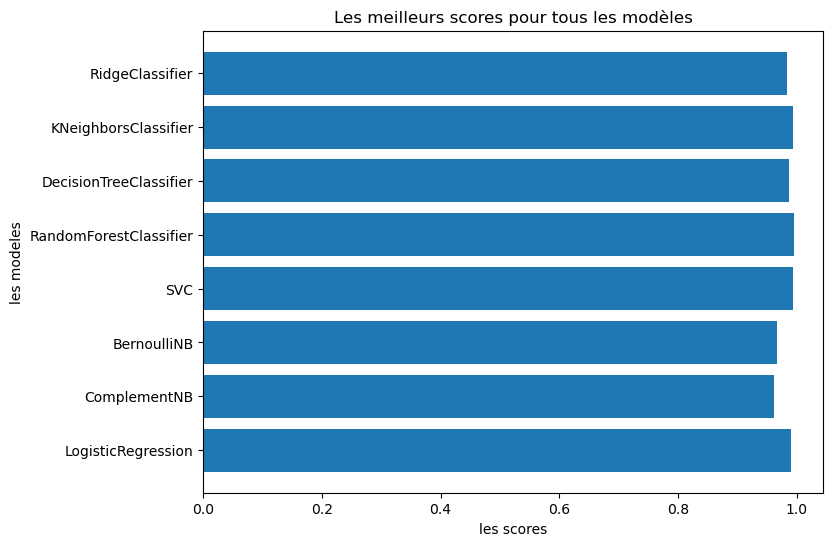

In [24]:
#Pour afficher le bar graphe des scores
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.barh(list(Modele_dic.keys()), [modele['score'] for modele in Modele_dic.values()])
ax.set_xlabel('les scores')
ax.set_ylabel('les modeles')
ax.set_title('Les meilleurs scores pour tous les modèles')

Voici la bar des scores de chaque modèle. le score représente la précision de chaque modèle. 4 modèles se démarquent : le KNN, RandomForest, LogisticRegression et SVC. Actuellement selon notre script ces modèles sont le plus performant pour le filtrage de spam. 

In [29]:
#-------------------------SMSDETECTOR--------------------------
#Entrez un SMS SVP: 
SmsTest=input("Entrez le SMS à tester")
print(f"##########################################################################################")
for model_name, model in Modele_dic.items():
    y = testModel(SmsTest,model['model'])
    
    print(f"Le model {model_name} a detecté que le msg est un: {y}")
    print(f"##########################################################################################")

##########################################################################################
Le model LogisticRegression a detecté que le msg est un: ['ham']
##########################################################################################
Le model ComplementNB a detecté que le msg est un: ['ham']
##########################################################################################
Le model BernoulliNB a detecté que le msg est un: ['ham']
##########################################################################################
Le model SVC a detecté que le msg est un: ['ham']
##########################################################################################
Le model RandomForestClassifier a detecté que le msg est un: ['ham']
##########################################################################################
Le model DecisionTreeClassifier a detecté que le msg est un: ['ham']
####################################################################################